In [184]:
#import necessary modules for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [185]:
#import runoff data for Fish River watershed
runoff = pd.read_csv('fish_river_flow.txt', sep='\t',skiprows=31, header=0)

In [186]:
runoff = runoff.set_index(['20d'])

In [187]:
runoff.index = pd.to_datetime(runoff.index)

In [188]:
#Cheeck the runoff data
runoff.head()

,5s,15s,6s,14n,10s
20d,,,,,
2000-01-01 00:00:00,USGS,2378500,CST,66.0,A:[91]
2000-01-01 00:30:00,USGS,2378500,CST,66.0,A:[91]
2000-01-01 01:00:00,USGS,2378500,CST,66.0,A:[91]
2000-01-01 01:30:00,USGS,2378500,CST,66.0,A:[91]
2000-01-01 02:00:00,USGS,2378500,CST,66.0,A:[91]


In [189]:
#drop unusable columns
cols = [0,1,2,4]
runoff.drop(runoff.columns[cols],axis=1,inplace=True)

In [195]:
#rename the runoff column
runoff = runoff.rename(columns={'14n': 'Runoff'})

In [196]:
runoff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311656 entries, 2000-01-01 00:00:00 to 2017-12-31 23:30:00
Data columns (total 1 columns):
Runoff    311656 non-null float64
dtypes: float64(1)
memory usage: 4.8 MB


In [197]:
#resample the data to daily
runoff_new = runoff.resample('D').mean()

In [198]:
runoff_new.tail()

,Runoff
20d,
2017-12-27,102.314583
2017-12-28,114.229167
2017-12-29,115.229167
2017-12-30,102.862500
2017-12-31,103.697917


In [211]:
runoff_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6575 entries, 2000-01-01 to 2017-12-31
Freq: D
Data columns (total 1 columns):
Runoff    6495 non-null float64
dtypes: float64(1)
memory usage: 102.7 KB


In [201]:
#import weather data from a nearby weather station at Robertsdale, AL
weather = pd.read_csv('robertsdale_weather.csv')

In [202]:
weather.head()

,STATION,NAME,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
0,USC00016988,"ROBERTSDALE, AL US",2000-01-01,NaN,NaN,0.0,0.0,0.0,24.4,9.4,13.3
1,USC00016988,"ROBERTSDALE, AL US",2000-01-02,NaN,NaN,0.0,0.0,0.0,25.0,13.3,19.4
2,USC00016988,"ROBERTSDALE, AL US",2000-01-03,NaN,NaN,0.0,0.0,0.0,25.6,19.4,20.0
3,USC00016988,"ROBERTSDALE, AL US",2000-01-04,NaN,NaN,4.1,0.0,0.0,25.0,13.3,13.9
4,USC00016988,"ROBERTSDALE, AL US",2000-01-05,NaN,NaN,0.0,0.0,0.0,17.8,-1.1,1.1


In [203]:
weather = weather.set_index(['DATE'])

In [204]:
weather.index = pd.to_datetime(weather.index)

In [205]:
#Use the relevant column for the study
weather = weather[['PRCP','TMAX','TMIN']]

In [206]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6489 entries, 2000-01-01 to 2017-12-31
Data columns (total 3 columns):
PRCP    6341 non-null float64
TMAX    6275 non-null float64
TMIN    6278 non-null float64
dtypes: float64(3)
memory usage: 202.8 KB


In [207]:
weather.isnull().sum()

PRCP    148
TMAX    214
TMIN    211
dtype: int64

In [208]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6489 entries, 2000-01-01 to 2017-12-31
Data columns (total 3 columns):
PRCP    6341 non-null float64
TMAX    6275 non-null float64
TMIN    6278 non-null float64
dtypes: float64(3)
memory usage: 202.8 KB


In [212]:
#Merge the runoff and weather data together
combined = pd.merge(weather,runoff_new,how="outer",left_index=True, right_index=True)

In [213]:
#check the combined dataset
combined.head()

,PRCP,TMAX,TMIN,Runoff
2000-01-01,0.0,24.4,9.4,65.458333
2000-01-02,0.0,25.0,13.3,65.145833
2000-01-03,0.0,25.6,19.4,64.583333
2000-01-04,4.1,25.0,13.3,65.208333
2000-01-05,0.0,17.8,-1.1,64.291667


In [214]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6575 entries, 2000-01-01 to 2017-12-31
Data columns (total 4 columns):
PRCP      6341 non-null float64
TMAX      6275 non-null float64
TMIN      6278 non-null float64
Runoff    6495 non-null float64
dtypes: float64(4)
memory usage: 256.8 KB


In [215]:
combined.PRCP.fillna(0,inplace=True)

In [216]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6575 entries, 2000-01-01 to 2017-12-31
Data columns (total 4 columns):
PRCP      6575 non-null float64
TMAX      6275 non-null float64
TMIN      6278 non-null float64
Runoff    6495 non-null float64
dtypes: float64(4)
memory usage: 256.8 KB


In [217]:
combined.fillna(method='ffill',inplace=True)

In [218]:
combined.describe()

,PRCP,TMAX,TMIN,Runoff
count,6575.000000,6575.000000,6575.000000,6575.000000
mean,4.545414,25.574768,13.755148,101.847366
std,15.278772,6.864929,8.224098,208.547926
min,0.000000,0.000000,-9.400000,34.810638
25%,0.000000,21.700000,7.200000,56.739583
50%,0.000000,26.700000,15.600000,71.091667
75%,0.300000,31.100000,21.100000,95.263542
max,365.500000,39.400000,28.300000,10081.666667


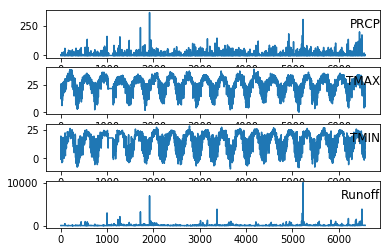

In [219]:
#plot all the time series variables
values = combined.values
i = 1
plt.figure()
groups = list(range(0,4))
for n in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:,n])
    plt.title(combined.columns[n], y=0.5, loc='right')
    i += 1
plt.show()

In [248]:
#converting values of features into array
array_values = combined.values

In [249]:
array_values

array([[  0.        ,  24.4       ,   9.4       ,  65.45833333],
       [  0.        ,  25.        ,  13.3       ,  65.14583333],
       [  0.        ,  25.6       ,  19.4       ,  64.58333333],
       ...,
       [  0.        ,   5.        ,   1.1       , 115.22916667],
       [  0.        ,  13.3       ,   1.1       , 102.8625    ],
       [  7.1       ,  15.        ,   5.        , 103.69791667]])

In [250]:
#scale all the features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(array_values)

In [251]:
df = pd.DataFrame(scaled)

In [252]:
df.head()

,0,1,2,3
0,0.000000,0.619289,0.498674,0.003050
1,0.000000,0.634518,0.602122,0.003019
2,0.000000,0.649746,0.763926,0.002963
3,0.011218,0.634518,0.602122,0.003026
4,0.000000,0.451777,0.220159,0.002934


In [253]:
type(scaled)

numpy.ndarray

In [254]:
cols = list()

In [255]:
cols = df.shift(0)

In [276]:
#transform the time series data by shifting the columns by one day and using them as variables

def transform(data, vars_in=1, vars_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    cols = list()
    names = list()
    for i in range(vars_in, 0, -1):
        cols.append(data.shift(i))
        names += ['var%d(t-%d)' %(j+1, i) for j in range(n_vars)]
    for i in range (0, vars_out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [('var%d(t)' %(j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' %(j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg


In [277]:
new_df = transform(df,1, 1)

In [278]:
#new dataset with the time series variables along with shifted (t-1) time series variables
new_df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.000000,0.619289,0.498674,0.003050,0.000000,0.634518,0.602122,0.003019
2,0.000000,0.634518,0.602122,0.003019,0.000000,0.649746,0.763926,0.002963
3,0.000000,0.649746,0.763926,0.002963,0.011218,0.634518,0.602122,0.003026
4,0.011218,0.634518,0.602122,0.003026,0.000000,0.451777,0.220159,0.002934
5,0.000000,0.451777,0.220159,0.002934,0.000000,0.309645,0.220159,0.002837


In [279]:
#dropping less important columns
new_df.drop(new_df.columns[[0,5,6]], axis=1, inplace=True)

In [280]:
new_df.head()

,var2(t-1),var3(t-1),var4(t-1),var1(t),var4(t)
1,0.619289,0.498674,0.003050,0.000000,0.003019
2,0.634518,0.602122,0.003019,0.000000,0.002963
3,0.649746,0.763926,0.002963,0.011218,0.003026
4,0.634518,0.602122,0.003026,0.000000,0.002934
5,0.451777,0.220159,0.002934,0.000000,0.002837


In [287]:
#seperating the dataset into training and testing datasets
values = new_df.values
n_train_days = 365*15
train = values[:n_train_days, :]
test = values[n_train_days:, :]

#specify input and output values
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:,-1]

train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5475, 1, 4) (5475,) (1099, 1, 4) (1099,)


In [288]:
#reshape the training dataset
train_X

array([[[0.61928934, 0.49867374, 0.00305048, 0.        ]],

       [[0.63451777, 0.60212202, 0.00301937, 0.        ]],

       [[0.64974619, 0.76392573, 0.00296338, 0.01121751]],

       ...,

       [[0.43654822, 0.29442971, 0.01257253, 0.        ]],

       [[0.36548223, 0.29442971, 0.00535592, 0.        ]],

       [[0.46446701, 0.33687003, 0.00487878, 0.07578659]]])

Train on 5475 samples, validate on 1099 samples
Epoch 1/200
 - 2s - loss: 0.0083 - val_loss: 0.0076
Epoch 2/200
 - 0s - loss: 0.0069 - val_loss: 0.0070
Epoch 3/200
 - 0s - loss: 0.0065 - val_loss: 0.0067
Epoch 4/200
 - 0s - loss: 0.0061 - val_loss: 0.0064
Epoch 5/200
 - 0s - loss: 0.0058 - val_loss: 0.0065
Epoch 6/200
 - 0s - loss: 0.0057 - val_loss: 0.0067
Epoch 7/200
 - 0s - loss: 0.0056 - val_loss: 0.0068
Epoch 8/200
 - 0s - loss: 0.0055 - val_loss: 0.0067
Epoch 9/200
 - 0s - loss: 0.0054 - val_loss: 0.0066
Epoch 10/200
 - 0s - loss: 0.0053 - val_loss: 0.0066
Epoch 11/200
 - 0s - loss: 0.0052 - val_loss: 0.0066
Epoch 12/200
 - 0s - loss: 0.0051 - val_loss: 0.0067
Epoch 13/200
 - 0s - loss: 0.0051 - val_loss: 0.0066
Epoch 14/200
 - 0s - loss: 0.0051 - val_loss: 0.0066
Epoch 15/200
 - 0s - loss: 0.0050 - val_loss: 0.0065
Epoch 16/200
 - 0s - loss: 0.0050 - val_loss: 0.0065
Epoch 17/200
 - 0s - loss: 0.0049 - val_loss: 0.0064
Epoch 18/200
 - 0s - loss: 0.0049 - val_loss: 0.0062
Epoch 1

Epoch 154/200
 - 0s - loss: 0.0038 - val_loss: 0.0048
Epoch 155/200
 - 0s - loss: 0.0038 - val_loss: 0.0048
Epoch 156/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 157/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 158/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 159/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 160/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 161/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 162/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 163/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 164/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 165/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 166/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 167/200
 - 0s - loss: 0.0037 - val_loss: 0.0047
Epoch 168/200
 - 0s - loss: 0.0037 - val_loss: 0.0048
Epoch 169/200
 - 0s - loss: 0.0037 - val_loss: 0.0047
Epoch 170/200
 - 0s - loss: 0.0037 - val_loss: 0.0047
Epoch 171/200
 - 0s - loss: 0.0037 - val_loss: 0.0047
Epoch 172/200
 - 0s - loss: 

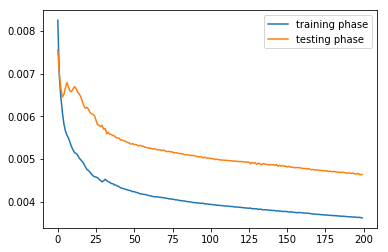

In [289]:
#specify the network with 30 hidden neurons in the first hidden layer

ann = Sequential()
ann.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
ann.add(Dense(1))
ann.compile(loss='mae', optimizer='adam')


#fit the model
model_run = ann.fit(train_X, train_y, epochs=200, batch_size=365, validation_data=(test_X, test_y), verbose=2, shuffle=False)

#plot model optimization
plt.plot(model_run.history['loss'], label='training phase')
plt.plot(model_run.history['val_loss'], label='testing phase')
plt.legend()
plt.show()

In [290]:
#make prediction
yfut = ann.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

invert_yfut = np.concatenate((yfut, test_X[:, 1:]), axis=1)
invert_yfut = scaler.inverse_transform(invert_yfut)
invert_yfut = invert_yfut[:,0]

#get actual values
test_y = test_y.reshape((len(test_y)), 1)
actual_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
actual_y = scaler.inverse_transform(actual_y)
actual_y = actual_y[:, 0]

#calculate error
r_square = r2_score(actual_y, invert_yfut)
rmse = np.sqrt(mean_squared_error(actual_y, invert_yfut))
print(actual_y)
print('The R-square is {}'.format(r_square))
print('Test error is {}'.format(rmse))

[3.83583547 2.13706254 1.62039728 ... 2.92558906 2.47569542 2.50608749]
The R-square is 0.3950848723919749
Test error is 5.161773599970554
